##### Copyright 2020 The TensorFlow Hub Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/classify_text_with_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/bert/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

# Classify text with BERT

This tutorial contains complete code to fine-tune BERT to perform sentiment analysis on a dataset of plain-text IMDB movie reviews.
In addition to training a model, you will learn how to preprocess text into an appropriate format.

In this notebook, you will:

- Load the IMDB dataset
- Load a BERT model from TensorFlow Hub
- Build your own model by combining BERT with a classifier
- Train your own model, fine-tuning BERT as part of that
- Save your model and use it to classify sentences

If you're new to working with the IMDB dataset, please see [Basic text classification](https://www.tensorflow.org/tutorials/keras/text_classification) for more details.

## About BERT

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers. 

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


## Setup


In [5]:
# A dependency of the preprocessing for BERT inputs
# !pip install -U "tensorflow-text==2.13.*"

You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [6]:
# !pip install "tf-models-official==2.13.*"

In [7]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

c:\Users\erkun\anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\erkun\anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want

## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/).

### Download the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.


In [15]:
## Uncomment this cell to download the Data from the url
# url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

# dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
#                                   untar=True, cache_dir='.',
#                                   cache_subdir='')

# dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
# train_dir = os.path.join(dataset_dir, 'train')

# # remove unused folders to make it easier to load the data
# remove_dir = os.path.join(train_dir, 'unsup')
# shutil.rmtree(remove_dir)

In [18]:
# url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

# dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
#                                   untar=True, cache_dir='.',
#                                   cache_subdir='')

dataset = '../../08_Datasets/IMDB_datasets/'
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
# # remove unused folders to make it easier to load the data
# remove_dir = os.path.join(train_dir, 'unsup')
# shutil.rmtree(remove_dir)

In [19]:
print(train_dir)
print(test_dir)

../../08_Datasets/IMDB_datasets\aclImdb\train
../../08_Datasets/IMDB_datasets\aclImdb\test


Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [20]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


Let's take a look at a few reviews.

In [21]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

## Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature. Follow the links above, or click on the [`tfhub.dev`](http://tfhub.dev) URL
printed after the next cell execution.

The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yield even better accuracy, but they are too big to be fine-tuned on a single GPU. You will be able to do that on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.

In [22]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## The preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

Note: You will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

In [23]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [25]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens. The number of tokens can be customized, and you can see more details on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

## Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [26]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [27]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262873  0.99280983 -0.18611865  0.3667382   0.15233754  0.6550446
  0.9681154  -0.948627    0.00216129 -0.9877731   0.06842719 -0.9763059 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.2894631   0.3432125   0.33231503 ...  0.21300879  0.71020824
  -0.05771083]
 [-0.28741956  0.31981033 -0.23018478 ...  0.58455044 -0.21329702
   0.72692096]
 [-0.66156983  0.68876874 -0.87432986 ...  0.10877332 -0.26173213
   0.4785546 ]
 ...
 [-0.22561109 -0.2892557  -0.07064363 ...  0.47566098  0.8327722
   0.40025353]
 [-0.29824188 -0.27473086 -0.05450502 ...  0.48849785  1.0955354
   0.18163365]
 [-0.4437817   0.00930776  0.07223777 ...  0.17290121  1.1833248
   0.07898013]]


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

## Define your model

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can follow the model's URL for documentation. Here specifically, you don't need to worry about it because the preprocessing model will take care of that for you.


In [28]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [29]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.1797537]], shape=(1, 1), dtype=float32)


The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

In [32]:
tf.keras.utils.plot_model(classifier_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [33]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [34]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [35]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [37]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5


ResourceExhaustedError: Graph execution error:

OOM when allocating tensor with shape[32,128,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node transformer/layer_3/dropout_2/dropout/random_uniform/RandomUniform}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_65201]

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [20]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


  1/782 [..............................] - ETA: 1:32 - loss: 0.2307 - binary_accuracy: 0.9062


  2/782 [..............................] - ETA: 1:12 - loss: 0.3713 - binary_accuracy: 0.8906


  3/782 [..............................] - ETA: 1:11 - loss: 0.4497 - binary_accuracy: 0.8646


  4/782 [..............................] - ETA: 1:11 - loss: 0.4742 - binary_accuracy: 0.8594


  5/782 [..............................] - ETA: 1:11 - loss: 0.4382 - binary_accuracy: 0.8625


  6/782 [..............................] - ETA: 1:11 - loss: 0.4247 - binary_accuracy: 0.8750


  7/782 [..............................] - ETA: 1:11 - loss: 0.4384 - binary_accuracy: 0.8705


  8/782 [..............................] - ETA: 1:11 - loss: 0.4519 - binary_accuracy: 0.8633


  9/782 [..............................] - ETA: 1:10 - loss: 0.4268 - binary_accuracy: 0.8646


 10/782 [..............................] - ETA: 1:10 - loss: 0.4302 - binary_accuracy: 0.8625


 11/782 [..............................] - ETA: 1:10 - loss: 0.4203 - binary_accuracy: 0.8636


 12/782 [..............................] - ETA: 1:09 - loss: 0.4167 - binary_accuracy: 0.8620


 13/782 [..............................] - ETA: 1:09 - loss: 0.4274 - binary_accuracy: 0.8582


 14/782 [..............................] - ETA: 1:09 - loss: 0.4394 - binary_accuracy: 0.8549


 15/782 [..............................] - ETA: 1:09 - loss: 0.4333 - binary_accuracy: 0.8542


 16/782 [..............................] - ETA: 1:09 - loss: 0.4343 - binary_accuracy: 0.8496


 17/782 [..............................] - ETA: 1:09 - loss: 0.4647 - binary_accuracy: 0.8474


 18/782 [..............................] - ETA: 1:09 - loss: 0.4552 - binary_accuracy: 0.8524


 19/782 [..............................] - ETA: 1:08 - loss: 0.4729 - binary_accuracy: 0.8487


 20/782 [..............................] - ETA: 1:08 - loss: 0.4772 - binary_accuracy: 0.8453


 21/782 [..............................] - ETA: 1:08 - loss: 0.4749 - binary_accuracy: 0.8467


 22/782 [..............................] - ETA: 1:08 - loss: 0.4653 - binary_accuracy: 0.8480


 23/782 [..............................] - ETA: 1:08 - loss: 0.4473 - binary_accuracy: 0.8546


 24/782 [..............................] - ETA: 1:08 - loss: 0.4468 - binary_accuracy: 0.8555


 25/782 [..............................] - ETA: 1:07 - loss: 0.4420 - binary_accuracy: 0.8575


 26/782 [..............................] - ETA: 1:07 - loss: 0.4472 - binary_accuracy: 0.8546


 27/782 [>.............................] - ETA: 1:07 - loss: 0.4495 - binary_accuracy: 0.8519


 28/782 [>.............................] - ETA: 1:07 - loss: 0.4497 - binary_accuracy: 0.8516


 29/782 [>.............................] - ETA: 1:07 - loss: 0.4526 - binary_accuracy: 0.8513


 30/782 [>.............................] - ETA: 1:07 - loss: 0.4485 - binary_accuracy: 0.8521


 31/782 [>.............................] - ETA: 1:07 - loss: 0.4462 - binary_accuracy: 0.8518


 32/782 [>.............................] - ETA: 1:06 - loss: 0.4399 - binary_accuracy: 0.8535


 33/782 [>.............................] - ETA: 1:06 - loss: 0.4439 - binary_accuracy: 0.8551


 34/782 [>.............................] - ETA: 1:06 - loss: 0.4432 - binary_accuracy: 0.8548


 35/782 [>.............................] - ETA: 1:06 - loss: 0.4452 - binary_accuracy: 0.8527


 36/782 [>.............................] - ETA: 1:06 - loss: 0.4535 - binary_accuracy: 0.8490


 37/782 [>.............................] - ETA: 1:06 - loss: 0.4480 - binary_accuracy: 0.8488


 38/782 [>.............................] - ETA: 1:06 - loss: 0.4538 - binary_accuracy: 0.8487


 39/782 [>.............................] - ETA: 1:06 - loss: 0.4595 - binary_accuracy: 0.8478


 40/782 [>.............................] - ETA: 1:06 - loss: 0.4546 - binary_accuracy: 0.8484


 41/782 [>.............................] - ETA: 1:06 - loss: 0.4601 - binary_accuracy: 0.8483


 42/782 [>.............................] - ETA: 1:06 - loss: 0.4565 - binary_accuracy: 0.8497


 43/782 [>.............................] - ETA: 1:06 - loss: 0.4504 - binary_accuracy: 0.8525


 44/782 [>.............................] - ETA: 1:05 - loss: 0.4432 - binary_accuracy: 0.8544


 45/782 [>.............................] - ETA: 1:05 - loss: 0.4431 - binary_accuracy: 0.8549


 46/782 [>.............................] - ETA: 1:05 - loss: 0.4423 - binary_accuracy: 0.8533


 47/782 [>.............................] - ETA: 1:05 - loss: 0.4397 - binary_accuracy: 0.8544


 48/782 [>.............................] - ETA: 1:05 - loss: 0.4386 - binary_accuracy: 0.8548


 49/782 [>.............................] - ETA: 1:05 - loss: 0.4369 - binary_accuracy: 0.8546


 50/782 [>.............................] - ETA: 1:05 - loss: 0.4387 - binary_accuracy: 0.8537


 51/782 [>.............................] - ETA: 1:05 - loss: 0.4402 - binary_accuracy: 0.8536


 52/782 [>.............................] - ETA: 1:05 - loss: 0.4367 - binary_accuracy: 0.8552


 53/782 [=>............................] - ETA: 1:05 - loss: 0.4417 - binary_accuracy: 0.8550


 54/782 [=>............................] - ETA: 1:05 - loss: 0.4439 - binary_accuracy: 0.8547


 55/782 [=>............................] - ETA: 1:04 - loss: 0.4432 - binary_accuracy: 0.8557


 56/782 [=>............................] - ETA: 1:04 - loss: 0.4444 - binary_accuracy: 0.8566


 57/782 [=>............................] - ETA: 1:04 - loss: 0.4444 - binary_accuracy: 0.8553


 58/782 [=>............................] - ETA: 1:04 - loss: 0.4466 - binary_accuracy: 0.8556


 59/782 [=>............................] - ETA: 1:04 - loss: 0.4428 - binary_accuracy: 0.8565


 60/782 [=>............................] - ETA: 1:04 - loss: 0.4400 - binary_accuracy: 0.8578


 61/782 [=>............................] - ETA: 1:04 - loss: 0.4419 - binary_accuracy: 0.8576


 62/782 [=>............................] - ETA: 1:04 - loss: 0.4487 - binary_accuracy: 0.8558


 63/782 [=>............................] - ETA: 1:04 - loss: 0.4459 - binary_accuracy: 0.8571


 64/782 [=>............................] - ETA: 1:04 - loss: 0.4421 - binary_accuracy: 0.8579


 65/782 [=>............................] - ETA: 1:04 - loss: 0.4483 - binary_accuracy: 0.8558


 66/782 [=>............................] - ETA: 1:04 - loss: 0.4499 - binary_accuracy: 0.8551


 67/782 [=>............................] - ETA: 1:03 - loss: 0.4526 - binary_accuracy: 0.8545


 68/782 [=>............................] - ETA: 1:03 - loss: 0.4543 - binary_accuracy: 0.8543


 69/782 [=>............................] - ETA: 1:03 - loss: 0.4523 - binary_accuracy: 0.8555


 70/782 [=>............................] - ETA: 1:03 - loss: 0.4517 - binary_accuracy: 0.8562


 71/782 [=>............................] - ETA: 1:03 - loss: 0.4561 - binary_accuracy: 0.8548


 72/782 [=>............................] - ETA: 1:03 - loss: 0.4518 - binary_accuracy: 0.8559


 73/782 [=>............................] - ETA: 1:03 - loss: 0.4518 - binary_accuracy: 0.8557


 74/782 [=>............................] - ETA: 1:03 - loss: 0.4505 - binary_accuracy: 0.8560


 75/782 [=>............................] - ETA: 1:03 - loss: 0.4499 - binary_accuracy: 0.8554


 76/782 [=>............................] - ETA: 1:03 - loss: 0.4489 - binary_accuracy: 0.8549


 77/782 [=>............................] - ETA: 1:02 - loss: 0.4456 - binary_accuracy: 0.8551


 78/782 [=>............................] - ETA: 1:02 - loss: 0.4465 - binary_accuracy: 0.8554


 79/782 [==>...........................] - ETA: 1:02 - loss: 0.4436 - binary_accuracy: 0.8560


 80/782 [==>...........................] - ETA: 1:02 - loss: 0.4468 - binary_accuracy: 0.8547


 81/782 [==>...........................] - ETA: 1:02 - loss: 0.4480 - binary_accuracy: 0.8542


 82/782 [==>...........................] - ETA: 1:02 - loss: 0.4464 - binary_accuracy: 0.8552


 83/782 [==>...........................] - ETA: 1:02 - loss: 0.4486 - binary_accuracy: 0.8554


 84/782 [==>...........................] - ETA: 1:02 - loss: 0.4501 - binary_accuracy: 0.8545


 85/782 [==>...........................] - ETA: 1:02 - loss: 0.4511 - binary_accuracy: 0.8533


 86/782 [==>...........................] - ETA: 1:02 - loss: 0.4496 - binary_accuracy: 0.8539


 87/782 [==>...........................] - ETA: 1:02 - loss: 0.4473 - binary_accuracy: 0.8542


 88/782 [==>...........................] - ETA: 1:02 - loss: 0.4457 - binary_accuracy: 0.8540


 89/782 [==>...........................] - ETA: 1:01 - loss: 0.4501 - binary_accuracy: 0.8529


 90/782 [==>...........................] - ETA: 1:01 - loss: 0.4475 - binary_accuracy: 0.8535


 91/782 [==>...........................] - ETA: 1:01 - loss: 0.4432 - binary_accuracy: 0.8544


 92/782 [==>...........................] - ETA: 1:01 - loss: 0.4448 - binary_accuracy: 0.8539


 93/782 [==>...........................] - ETA: 1:01 - loss: 0.4457 - binary_accuracy: 0.8535


 94/782 [==>...........................] - ETA: 1:01 - loss: 0.4446 - binary_accuracy: 0.8541


 95/782 [==>...........................] - ETA: 1:01 - loss: 0.4435 - binary_accuracy: 0.8546


 96/782 [==>...........................] - ETA: 1:01 - loss: 0.4406 - binary_accuracy: 0.8551


 97/782 [==>...........................] - ETA: 1:01 - loss: 0.4401 - binary_accuracy: 0.8547


 98/782 [==>...........................] - ETA: 1:01 - loss: 0.4389 - binary_accuracy: 0.8549


 99/782 [==>...........................] - ETA: 1:01 - loss: 0.4366 - binary_accuracy: 0.8551


100/782 [==>...........................] - ETA: 1:00 - loss: 0.4340 - binary_accuracy: 0.8556


101/782 [==>...........................] - ETA: 1:00 - loss: 0.4387 - binary_accuracy: 0.8540


102/782 [==>...........................] - ETA: 1:00 - loss: 0.4382 - binary_accuracy: 0.8542


103/782 [==>...........................] - ETA: 1:00 - loss: 0.4395 - binary_accuracy: 0.8538


104/782 [==>...........................] - ETA: 1:00 - loss: 0.4398 - binary_accuracy: 0.8534


105/782 [===>..........................] - ETA: 1:00 - loss: 0.4439 - binary_accuracy: 0.8521


106/782 [===>..........................] - ETA: 1:00 - loss: 0.4457 - binary_accuracy: 0.8523


107/782 [===>..........................] - ETA: 1:00 - loss: 0.4448 - binary_accuracy: 0.8522


108/782 [===>..........................] - ETA: 1:00 - loss: 0.4425 - binary_accuracy: 0.8530


109/782 [===>..........................] - ETA: 1:00 - loss: 0.4421 - binary_accuracy: 0.8529


110/782 [===>..........................] - ETA: 1:00 - loss: 0.4412 - binary_accuracy: 0.8531


111/782 [===>..........................] - ETA: 1:00 - loss: 0.4392 - binary_accuracy: 0.8530


112/782 [===>..........................] - ETA: 59s - loss: 0.4375 - binary_accuracy: 0.8532 


113/782 [===>..........................] - ETA: 59s - loss: 0.4393 - binary_accuracy: 0.8534


114/782 [===>..........................] - ETA: 59s - loss: 0.4388 - binary_accuracy: 0.8536


115/782 [===>..........................] - ETA: 59s - loss: 0.4400 - binary_accuracy: 0.8538


116/782 [===>..........................] - ETA: 59s - loss: 0.4413 - binary_accuracy: 0.8537


117/782 [===>..........................] - ETA: 59s - loss: 0.4430 - binary_accuracy: 0.8531


118/782 [===>..........................] - ETA: 59s - loss: 0.4448 - binary_accuracy: 0.8533


119/782 [===>..........................] - ETA: 59s - loss: 0.4427 - binary_accuracy: 0.8543


120/782 [===>..........................] - ETA: 59s - loss: 0.4407 - binary_accuracy: 0.8552


121/782 [===>..........................] - ETA: 59s - loss: 0.4415 - binary_accuracy: 0.8551


122/782 [===>..........................] - ETA: 59s - loss: 0.4411 - binary_accuracy: 0.8548


123/782 [===>..........................] - ETA: 58s - loss: 0.4418 - binary_accuracy: 0.8547


124/782 [===>..........................] - ETA: 58s - loss: 0.4423 - binary_accuracy: 0.8541


125/782 [===>..........................] - ETA: 58s - loss: 0.4466 - binary_accuracy: 0.8535


126/782 [===>..........................] - ETA: 58s - loss: 0.4453 - binary_accuracy: 0.8539


127/782 [===>..........................] - ETA: 58s - loss: 0.4464 - binary_accuracy: 0.8538


128/782 [===>..........................] - ETA: 58s - loss: 0.4457 - binary_accuracy: 0.8542


129/782 [===>..........................] - ETA: 58s - loss: 0.4454 - binary_accuracy: 0.8544


130/782 [===>..........................] - ETA: 58s - loss: 0.4428 - binary_accuracy: 0.8553


131/782 [====>.........................] - ETA: 58s - loss: 0.4441 - binary_accuracy: 0.8550


132/782 [====>.........................] - ETA: 58s - loss: 0.4470 - binary_accuracy: 0.8542


133/782 [====>.........................] - ETA: 58s - loss: 0.4493 - binary_accuracy: 0.8536


134/782 [====>.........................] - ETA: 58s - loss: 0.4489 - binary_accuracy: 0.8533


135/782 [====>.........................] - ETA: 58s - loss: 0.4479 - binary_accuracy: 0.8532


136/782 [====>.........................] - ETA: 57s - loss: 0.4488 - binary_accuracy: 0.8529


137/782 [====>.........................] - ETA: 57s - loss: 0.4489 - binary_accuracy: 0.8533


138/782 [====>.........................] - ETA: 57s - loss: 0.4492 - binary_accuracy: 0.8530


139/782 [====>.........................] - ETA: 57s - loss: 0.4468 - binary_accuracy: 0.8536


140/782 [====>.........................] - ETA: 57s - loss: 0.4471 - binary_accuracy: 0.8536


141/782 [====>.........................] - ETA: 57s - loss: 0.4455 - binary_accuracy: 0.8544


142/782 [====>.........................] - ETA: 57s - loss: 0.4443 - binary_accuracy: 0.8548


143/782 [====>.........................] - ETA: 57s - loss: 0.4421 - binary_accuracy: 0.8551


144/782 [====>.........................] - ETA: 57s - loss: 0.4417 - binary_accuracy: 0.8548


145/782 [====>.........................] - ETA: 57s - loss: 0.4423 - binary_accuracy: 0.8547


146/782 [====>.........................] - ETA: 57s - loss: 0.4412 - binary_accuracy: 0.8551


147/782 [====>.........................] - ETA: 57s - loss: 0.4393 - binary_accuracy: 0.8554


148/782 [====>.........................] - ETA: 56s - loss: 0.4385 - binary_accuracy: 0.8556


149/782 [====>.........................] - ETA: 56s - loss: 0.4360 - binary_accuracy: 0.8563


150/782 [====>.........................] - ETA: 56s - loss: 0.4345 - binary_accuracy: 0.8569


151/782 [====>.........................] - ETA: 56s - loss: 0.4350 - binary_accuracy: 0.8566


152/782 [====>.........................] - ETA: 56s - loss: 0.4351 - binary_accuracy: 0.8561


153/782 [====>.........................] - ETA: 56s - loss: 0.4378 - binary_accuracy: 0.8554


154/782 [====>.........................] - ETA: 56s - loss: 0.4352 - binary_accuracy: 0.8563


155/782 [====>.........................] - ETA: 56s - loss: 0.4346 - binary_accuracy: 0.8565


156/782 [====>.........................] - ETA: 56s - loss: 0.4322 - binary_accuracy: 0.8570


157/782 [=====>........................] - ETA: 56s - loss: 0.4325 - binary_accuracy: 0.8569


158/782 [=====>........................] - ETA: 56s - loss: 0.4309 - binary_accuracy: 0.8572


159/782 [=====>........................] - ETA: 55s - loss: 0.4316 - binary_accuracy: 0.8573


160/782 [=====>........................] - ETA: 55s - loss: 0.4311 - binary_accuracy: 0.8572


161/782 [=====>........................] - ETA: 55s - loss: 0.4318 - binary_accuracy: 0.8571


162/782 [=====>........................] - ETA: 55s - loss: 0.4334 - binary_accuracy: 0.8569


163/782 [=====>........................] - ETA: 55s - loss: 0.4381 - binary_accuracy: 0.8558


164/782 [=====>........................] - ETA: 55s - loss: 0.4381 - binary_accuracy: 0.8559


165/782 [=====>........................] - ETA: 55s - loss: 0.4386 - binary_accuracy: 0.8555


166/782 [=====>........................] - ETA: 55s - loss: 0.4399 - binary_accuracy: 0.8552


167/782 [=====>........................] - ETA: 55s - loss: 0.4416 - binary_accuracy: 0.8550


168/782 [=====>........................] - ETA: 55s - loss: 0.4414 - binary_accuracy: 0.8551


169/782 [=====>........................] - ETA: 55s - loss: 0.4401 - binary_accuracy: 0.8550


170/782 [=====>........................] - ETA: 55s - loss: 0.4401 - binary_accuracy: 0.8551


171/782 [=====>........................] - ETA: 54s - loss: 0.4388 - binary_accuracy: 0.8554


172/782 [=====>........................] - ETA: 54s - loss: 0.4396 - binary_accuracy: 0.8552


173/782 [=====>........................] - ETA: 54s - loss: 0.4402 - binary_accuracy: 0.8549


174/782 [=====>........................] - ETA: 54s - loss: 0.4468 - binary_accuracy: 0.8534


175/782 [=====>........................] - ETA: 54s - loss: 0.4490 - binary_accuracy: 0.8527


176/782 [=====>........................] - ETA: 54s - loss: 0.4496 - binary_accuracy: 0.8523


177/782 [=====>........................] - ETA: 54s - loss: 0.4492 - binary_accuracy: 0.8524


178/782 [=====>........................] - ETA: 54s - loss: 0.4481 - binary_accuracy: 0.8527


179/782 [=====>........................] - ETA: 54s - loss: 0.4468 - binary_accuracy: 0.8534


180/782 [=====>........................] - ETA: 54s - loss: 0.4478 - binary_accuracy: 0.8530


181/782 [=====>........................] - ETA: 54s - loss: 0.4483 - binary_accuracy: 0.8532


182/782 [=====>........................] - ETA: 53s - loss: 0.4493 - binary_accuracy: 0.8529


183/782 [======>.......................] - ETA: 53s - loss: 0.4500 - binary_accuracy: 0.8528


184/782 [======>.......................] - ETA: 53s - loss: 0.4480 - binary_accuracy: 0.8534


185/782 [======>.......................] - ETA: 53s - loss: 0.4525 - binary_accuracy: 0.8524


186/782 [======>.......................] - ETA: 53s - loss: 0.4509 - binary_accuracy: 0.8528


187/782 [======>.......................] - ETA: 53s - loss: 0.4510 - binary_accuracy: 0.8528


188/782 [======>.......................] - ETA: 53s - loss: 0.4517 - binary_accuracy: 0.8526


189/782 [======>.......................] - ETA: 53s - loss: 0.4502 - binary_accuracy: 0.8527


190/782 [======>.......................] - ETA: 53s - loss: 0.4490 - binary_accuracy: 0.8530


191/782 [======>.......................] - ETA: 53s - loss: 0.4486 - binary_accuracy: 0.8527


192/782 [======>.......................] - ETA: 53s - loss: 0.4488 - binary_accuracy: 0.8524


193/782 [======>.......................] - ETA: 53s - loss: 0.4485 - binary_accuracy: 0.8523


194/782 [======>.......................] - ETA: 52s - loss: 0.4497 - binary_accuracy: 0.8518


195/782 [======>.......................] - ETA: 52s - loss: 0.4505 - binary_accuracy: 0.8518


196/782 [======>.......................] - ETA: 52s - loss: 0.4504 - binary_accuracy: 0.8519


197/782 [======>.......................] - ETA: 52s - loss: 0.4520 - binary_accuracy: 0.8517


198/782 [======>.......................] - ETA: 52s - loss: 0.4509 - binary_accuracy: 0.8521


199/782 [======>.......................] - ETA: 52s - loss: 0.4517 - binary_accuracy: 0.8519


200/782 [======>.......................] - ETA: 52s - loss: 0.4518 - binary_accuracy: 0.8522


201/782 [======>.......................] - ETA: 52s - loss: 0.4560 - binary_accuracy: 0.8512


202/782 [======>.......................] - ETA: 52s - loss: 0.4547 - binary_accuracy: 0.8516


203/782 [======>.......................] - ETA: 52s - loss: 0.4558 - binary_accuracy: 0.8511


204/782 [======>.......................] - ETA: 52s - loss: 0.4540 - binary_accuracy: 0.8517


205/782 [======>.......................] - ETA: 51s - loss: 0.4524 - binary_accuracy: 0.8521


206/782 [======>.......................] - ETA: 51s - loss: 0.4513 - binary_accuracy: 0.8522


207/782 [======>.......................] - ETA: 51s - loss: 0.4519 - binary_accuracy: 0.8519


208/782 [======>.......................] - ETA: 51s - loss: 0.4517 - binary_accuracy: 0.8519


209/782 [=======>......................] - ETA: 51s - loss: 0.4521 - binary_accuracy: 0.8517


210/782 [=======>......................] - ETA: 51s - loss: 0.4523 - binary_accuracy: 0.8516


211/782 [=======>......................] - ETA: 51s - loss: 0.4523 - binary_accuracy: 0.8517


212/782 [=======>......................] - ETA: 51s - loss: 0.4516 - binary_accuracy: 0.8519


213/782 [=======>......................] - ETA: 51s - loss: 0.4510 - binary_accuracy: 0.8521


214/782 [=======>......................] - ETA: 51s - loss: 0.4507 - binary_accuracy: 0.8522


215/782 [=======>......................] - ETA: 51s - loss: 0.4499 - binary_accuracy: 0.8525


216/782 [=======>......................] - ETA: 50s - loss: 0.4501 - binary_accuracy: 0.8523


217/782 [=======>......................] - ETA: 50s - loss: 0.4498 - binary_accuracy: 0.8522


218/782 [=======>......................] - ETA: 50s - loss: 0.4497 - binary_accuracy: 0.8521


219/782 [=======>......................] - ETA: 50s - loss: 0.4491 - binary_accuracy: 0.8523


220/782 [=======>......................] - ETA: 50s - loss: 0.4498 - binary_accuracy: 0.8520


221/782 [=======>......................] - ETA: 50s - loss: 0.4497 - binary_accuracy: 0.8520


222/782 [=======>......................] - ETA: 50s - loss: 0.4490 - binary_accuracy: 0.8523


223/782 [=======>......................] - ETA: 50s - loss: 0.4490 - binary_accuracy: 0.8523


224/782 [=======>......................] - ETA: 50s - loss: 0.4497 - binary_accuracy: 0.8521


225/782 [=======>......................] - ETA: 50s - loss: 0.4508 - binary_accuracy: 0.8518


226/782 [=======>......................] - ETA: 50s - loss: 0.4505 - binary_accuracy: 0.8519


227/782 [=======>......................] - ETA: 49s - loss: 0.4494 - binary_accuracy: 0.8517


228/782 [=======>......................] - ETA: 49s - loss: 0.4511 - binary_accuracy: 0.8514


229/782 [=======>......................] - ETA: 49s - loss: 0.4515 - binary_accuracy: 0.8517


230/782 [=======>......................] - ETA: 49s - loss: 0.4503 - binary_accuracy: 0.8520


231/782 [=======>......................] - ETA: 49s - loss: 0.4502 - binary_accuracy: 0.8520


232/782 [=======>......................] - ETA: 49s - loss: 0.4502 - binary_accuracy: 0.8521


233/782 [=======>......................] - ETA: 49s - loss: 0.4499 - binary_accuracy: 0.8522


234/782 [=======>......................] - ETA: 49s - loss: 0.4495 - binary_accuracy: 0.8523


235/782 [========>.....................] - ETA: 49s - loss: 0.4489 - binary_accuracy: 0.8525


236/782 [========>.....................] - ETA: 49s - loss: 0.4488 - binary_accuracy: 0.8526


237/782 [========>.....................] - ETA: 49s - loss: 0.4481 - binary_accuracy: 0.8528


238/782 [========>.....................] - ETA: 48s - loss: 0.4488 - binary_accuracy: 0.8529


239/782 [========>.....................] - ETA: 48s - loss: 0.4475 - binary_accuracy: 0.8534


240/782 [========>.....................] - ETA: 48s - loss: 0.4467 - binary_accuracy: 0.8536


241/782 [========>.....................] - ETA: 48s - loss: 0.4463 - binary_accuracy: 0.8537


242/782 [========>.....................] - ETA: 48s - loss: 0.4465 - binary_accuracy: 0.8536


243/782 [========>.....................] - ETA: 48s - loss: 0.4489 - binary_accuracy: 0.8530


244/782 [========>.....................] - ETA: 48s - loss: 0.4495 - binary_accuracy: 0.8530


245/782 [========>.....................] - ETA: 48s - loss: 0.4481 - binary_accuracy: 0.8533


246/782 [========>.....................] - ETA: 48s - loss: 0.4480 - binary_accuracy: 0.8532


247/782 [========>.....................] - ETA: 48s - loss: 0.4481 - binary_accuracy: 0.8532


248/782 [========>.....................] - ETA: 48s - loss: 0.4483 - binary_accuracy: 0.8533


249/782 [========>.....................] - ETA: 47s - loss: 0.4482 - binary_accuracy: 0.8534


250/782 [========>.....................] - ETA: 47s - loss: 0.4488 - binary_accuracy: 0.8533


251/782 [========>.....................] - ETA: 47s - loss: 0.4492 - binary_accuracy: 0.8533


252/782 [========>.....................] - ETA: 47s - loss: 0.4489 - binary_accuracy: 0.8535


253/782 [========>.....................] - ETA: 47s - loss: 0.4492 - binary_accuracy: 0.8534


254/782 [========>.....................] - ETA: 47s - loss: 0.4479 - binary_accuracy: 0.8538


255/782 [========>.....................] - ETA: 47s - loss: 0.4479 - binary_accuracy: 0.8536


256/782 [========>.....................] - ETA: 47s - loss: 0.4464 - binary_accuracy: 0.8540


257/782 [========>.....................] - ETA: 47s - loss: 0.4466 - binary_accuracy: 0.8538


258/782 [========>.....................] - ETA: 47s - loss: 0.4459 - binary_accuracy: 0.8540


259/782 [========>.....................] - ETA: 47s - loss: 0.4454 - binary_accuracy: 0.8540


260/782 [========>.....................] - ETA: 47s - loss: 0.4448 - binary_accuracy: 0.8542


261/782 [=========>....................] - ETA: 46s - loss: 0.4448 - binary_accuracy: 0.8540


262/782 [=========>....................] - ETA: 46s - loss: 0.4463 - binary_accuracy: 0.8538


263/782 [=========>....................] - ETA: 46s - loss: 0.4451 - binary_accuracy: 0.8542


264/782 [=========>....................] - ETA: 46s - loss: 0.4456 - binary_accuracy: 0.8542


265/782 [=========>....................] - ETA: 46s - loss: 0.4462 - binary_accuracy: 0.8541


266/782 [=========>....................] - ETA: 46s - loss: 0.4460 - binary_accuracy: 0.8543


267/782 [=========>....................] - ETA: 46s - loss: 0.4460 - binary_accuracy: 0.8544


268/782 [=========>....................] - ETA: 46s - loss: 0.4461 - binary_accuracy: 0.8545


269/782 [=========>....................] - ETA: 46s - loss: 0.4467 - binary_accuracy: 0.8543


270/782 [=========>....................] - ETA: 46s - loss: 0.4464 - binary_accuracy: 0.8544


271/782 [=========>....................] - ETA: 46s - loss: 0.4463 - binary_accuracy: 0.8546


272/782 [=========>....................] - ETA: 45s - loss: 0.4467 - binary_accuracy: 0.8547


273/782 [=========>....................] - ETA: 45s - loss: 0.4469 - binary_accuracy: 0.8545


274/782 [=========>....................] - ETA: 45s - loss: 0.4457 - binary_accuracy: 0.8547


275/782 [=========>....................] - ETA: 45s - loss: 0.4465 - binary_accuracy: 0.8544


276/782 [=========>....................] - ETA: 45s - loss: 0.4457 - binary_accuracy: 0.8547


277/782 [=========>....................] - ETA: 45s - loss: 0.4473 - binary_accuracy: 0.8546


278/782 [=========>....................] - ETA: 45s - loss: 0.4484 - binary_accuracy: 0.8543


279/782 [=========>....................] - ETA: 45s - loss: 0.4481 - binary_accuracy: 0.8545


280/782 [=========>....................] - ETA: 45s - loss: 0.4475 - binary_accuracy: 0.8546


281/782 [=========>....................] - ETA: 45s - loss: 0.4474 - binary_accuracy: 0.8545


282/782 [=========>....................] - ETA: 45s - loss: 0.4470 - binary_accuracy: 0.8546


283/782 [=========>....................] - ETA: 44s - loss: 0.4459 - binary_accuracy: 0.8548


284/782 [=========>....................] - ETA: 44s - loss: 0.4450 - binary_accuracy: 0.8551


285/782 [=========>....................] - ETA: 44s - loss: 0.4448 - binary_accuracy: 0.8550


286/782 [=========>....................] - ETA: 44s - loss: 0.4444 - binary_accuracy: 0.8552


287/782 [==========>...................] - ETA: 44s - loss: 0.4448 - binary_accuracy: 0.8553


288/782 [==========>...................] - ETA: 44s - loss: 0.4451 - binary_accuracy: 0.8550


289/782 [==========>...................] - ETA: 44s - loss: 0.4444 - binary_accuracy: 0.8553


290/782 [==========>...................] - ETA: 44s - loss: 0.4454 - binary_accuracy: 0.8553


291/782 [==========>...................] - ETA: 44s - loss: 0.4447 - binary_accuracy: 0.8553


292/782 [==========>...................] - ETA: 44s - loss: 0.4435 - binary_accuracy: 0.8557


293/782 [==========>...................] - ETA: 44s - loss: 0.4440 - binary_accuracy: 0.8558


294/782 [==========>...................] - ETA: 43s - loss: 0.4439 - binary_accuracy: 0.8559


295/782 [==========>...................] - ETA: 43s - loss: 0.4434 - binary_accuracy: 0.8560


296/782 [==========>...................] - ETA: 43s - loss: 0.4429 - binary_accuracy: 0.8562


297/782 [==========>...................] - ETA: 43s - loss: 0.4429 - binary_accuracy: 0.8562


298/782 [==========>...................] - ETA: 43s - loss: 0.4422 - binary_accuracy: 0.8561


299/782 [==========>...................] - ETA: 43s - loss: 0.4421 - binary_accuracy: 0.8562


300/782 [==========>...................] - ETA: 43s - loss: 0.4429 - binary_accuracy: 0.8561


301/782 [==========>...................] - ETA: 43s - loss: 0.4420 - binary_accuracy: 0.8563


302/782 [==========>...................] - ETA: 43s - loss: 0.4412 - binary_accuracy: 0.8567


303/782 [==========>...................] - ETA: 43s - loss: 0.4411 - binary_accuracy: 0.8565


304/782 [==========>...................] - ETA: 43s - loss: 0.4414 - binary_accuracy: 0.8566


305/782 [==========>...................] - ETA: 42s - loss: 0.4409 - binary_accuracy: 0.8564


306/782 [==========>...................] - ETA: 42s - loss: 0.4406 - binary_accuracy: 0.8565


307/782 [==========>...................] - ETA: 42s - loss: 0.4410 - binary_accuracy: 0.8563


308/782 [==========>...................] - ETA: 42s - loss: 0.4404 - binary_accuracy: 0.8561


309/782 [==========>...................] - ETA: 42s - loss: 0.4409 - binary_accuracy: 0.8561


310/782 [==========>...................] - ETA: 42s - loss: 0.4412 - binary_accuracy: 0.8559


311/782 [==========>...................] - ETA: 42s - loss: 0.4414 - binary_accuracy: 0.8558


312/782 [==========>...................] - ETA: 42s - loss: 0.4409 - binary_accuracy: 0.8560


313/782 [===========>..................] - ETA: 42s - loss: 0.4419 - binary_accuracy: 0.8554


314/782 [===========>..................] - ETA: 42s - loss: 0.4414 - binary_accuracy: 0.8554


315/782 [===========>..................] - ETA: 42s - loss: 0.4410 - binary_accuracy: 0.8556


316/782 [===========>..................] - ETA: 41s - loss: 0.4416 - binary_accuracy: 0.8555


317/782 [===========>..................] - ETA: 41s - loss: 0.4410 - binary_accuracy: 0.8558


318/782 [===========>..................] - ETA: 41s - loss: 0.4411 - binary_accuracy: 0.8558


319/782 [===========>..................] - ETA: 41s - loss: 0.4409 - binary_accuracy: 0.8560


320/782 [===========>..................] - ETA: 41s - loss: 0.4407 - binary_accuracy: 0.8561


321/782 [===========>..................] - ETA: 41s - loss: 0.4416 - binary_accuracy: 0.8557


322/782 [===========>..................] - ETA: 41s - loss: 0.4410 - binary_accuracy: 0.8559


323/782 [===========>..................] - ETA: 41s - loss: 0.4415 - binary_accuracy: 0.8557


324/782 [===========>..................] - ETA: 41s - loss: 0.4408 - binary_accuracy: 0.8559


325/782 [===========>..................] - ETA: 41s - loss: 0.4405 - binary_accuracy: 0.8561


326/782 [===========>..................] - ETA: 41s - loss: 0.4419 - binary_accuracy: 0.8558


327/782 [===========>..................] - ETA: 40s - loss: 0.4422 - binary_accuracy: 0.8559


328/782 [===========>..................] - ETA: 40s - loss: 0.4426 - binary_accuracy: 0.8559


329/782 [===========>..................] - ETA: 40s - loss: 0.4428 - binary_accuracy: 0.8559


330/782 [===========>..................] - ETA: 40s - loss: 0.4436 - binary_accuracy: 0.8559


331/782 [===========>..................] - ETA: 40s - loss: 0.4430 - binary_accuracy: 0.8561


332/782 [===========>..................] - ETA: 40s - loss: 0.4433 - binary_accuracy: 0.8560


333/782 [===========>..................] - ETA: 40s - loss: 0.4433 - binary_accuracy: 0.8561


334/782 [===========>..................] - ETA: 40s - loss: 0.4433 - binary_accuracy: 0.8562


335/782 [===========>..................] - ETA: 40s - loss: 0.4428 - binary_accuracy: 0.8564


336/782 [===========>..................] - ETA: 40s - loss: 0.4423 - binary_accuracy: 0.8567


337/782 [===========>..................] - ETA: 40s - loss: 0.4424 - binary_accuracy: 0.8566


338/782 [===========>..................] - ETA: 39s - loss: 0.4434 - binary_accuracy: 0.8563


339/782 [============>.................] - ETA: 39s - loss: 0.4432 - binary_accuracy: 0.8564


340/782 [============>.................] - ETA: 39s - loss: 0.4425 - binary_accuracy: 0.8566


341/782 [============>.................] - ETA: 39s - loss: 0.4423 - binary_accuracy: 0.8568


342/782 [============>.................] - ETA: 39s - loss: 0.4419 - binary_accuracy: 0.8568


343/782 [============>.................] - ETA: 39s - loss: 0.4416 - binary_accuracy: 0.8570


344/782 [============>.................] - ETA: 39s - loss: 0.4412 - binary_accuracy: 0.8568


345/782 [============>.................] - ETA: 39s - loss: 0.4415 - binary_accuracy: 0.8568


346/782 [============>.................] - ETA: 39s - loss: 0.4417 - binary_accuracy: 0.8568


347/782 [============>.................] - ETA: 39s - loss: 0.4409 - binary_accuracy: 0.8569


348/782 [============>.................] - ETA: 39s - loss: 0.4401 - binary_accuracy: 0.8570


349/782 [============>.................] - ETA: 38s - loss: 0.4397 - binary_accuracy: 0.8572


350/782 [============>.................] - ETA: 38s - loss: 0.4400 - binary_accuracy: 0.8571


351/782 [============>.................] - ETA: 38s - loss: 0.4401 - binary_accuracy: 0.8569


352/782 [============>.................] - ETA: 38s - loss: 0.4396 - binary_accuracy: 0.8571


353/782 [============>.................] - ETA: 38s - loss: 0.4399 - binary_accuracy: 0.8570


354/782 [============>.................] - ETA: 38s - loss: 0.4394 - binary_accuracy: 0.8573


355/782 [============>.................] - ETA: 38s - loss: 0.4416 - binary_accuracy: 0.8569


356/782 [============>.................] - ETA: 38s - loss: 0.4410 - binary_accuracy: 0.8569


357/782 [============>.................] - ETA: 38s - loss: 0.4426 - binary_accuracy: 0.8564


358/782 [============>.................] - ETA: 38s - loss: 0.4429 - binary_accuracy: 0.8563


359/782 [============>.................] - ETA: 38s - loss: 0.4427 - binary_accuracy: 0.8563


360/782 [============>.................] - ETA: 37s - loss: 0.4425 - binary_accuracy: 0.8563


361/782 [============>.................] - ETA: 37s - loss: 0.4420 - binary_accuracy: 0.8564


362/782 [============>.................] - ETA: 37s - loss: 0.4411 - binary_accuracy: 0.8565


363/782 [============>.................] - ETA: 37s - loss: 0.4402 - binary_accuracy: 0.8567


364/782 [============>.................] - ETA: 37s - loss: 0.4398 - binary_accuracy: 0.8569


365/782 [=============>................] - ETA: 37s - loss: 0.4401 - binary_accuracy: 0.8566


366/782 [=============>................] - ETA: 37s - loss: 0.4414 - binary_accuracy: 0.8562


367/782 [=============>................] - ETA: 37s - loss: 0.4410 - binary_accuracy: 0.8564


368/782 [=============>................] - ETA: 37s - loss: 0.4405 - binary_accuracy: 0.8564


369/782 [=============>................] - ETA: 37s - loss: 0.4404 - binary_accuracy: 0.8563


370/782 [=============>................] - ETA: 37s - loss: 0.4407 - binary_accuracy: 0.8563


371/782 [=============>................] - ETA: 36s - loss: 0.4407 - binary_accuracy: 0.8564


372/782 [=============>................] - ETA: 36s - loss: 0.4411 - binary_accuracy: 0.8564


373/782 [=============>................] - ETA: 36s - loss: 0.4406 - binary_accuracy: 0.8566


374/782 [=============>................] - ETA: 36s - loss: 0.4419 - binary_accuracy: 0.8562


375/782 [=============>................] - ETA: 36s - loss: 0.4417 - binary_accuracy: 0.8563


376/782 [=============>................] - ETA: 36s - loss: 0.4412 - binary_accuracy: 0.8564


377/782 [=============>................] - ETA: 36s - loss: 0.4407 - binary_accuracy: 0.8565


378/782 [=============>................] - ETA: 36s - loss: 0.4410 - binary_accuracy: 0.8564


379/782 [=============>................] - ETA: 36s - loss: 0.4407 - binary_accuracy: 0.8564


380/782 [=============>................] - ETA: 36s - loss: 0.4411 - binary_accuracy: 0.8562


381/782 [=============>................] - ETA: 36s - loss: 0.4419 - binary_accuracy: 0.8561


382/782 [=============>................] - ETA: 35s - loss: 0.4413 - binary_accuracy: 0.8563


383/782 [=============>................] - ETA: 35s - loss: 0.4415 - binary_accuracy: 0.8563


384/782 [=============>................] - ETA: 35s - loss: 0.4421 - binary_accuracy: 0.8562


385/782 [=============>................] - ETA: 35s - loss: 0.4417 - binary_accuracy: 0.8563


386/782 [=============>................] - ETA: 35s - loss: 0.4418 - binary_accuracy: 0.8564


387/782 [=============>................] - ETA: 35s - loss: 0.4426 - binary_accuracy: 0.8563


388/782 [=============>................] - ETA: 35s - loss: 0.4426 - binary_accuracy: 0.8562


389/782 [=============>................] - ETA: 35s - loss: 0.4432 - binary_accuracy: 0.8561


390/782 [=============>................] - ETA: 35s - loss: 0.4434 - binary_accuracy: 0.8562


391/782 [==============>...............] - ETA: 35s - loss: 0.4440 - binary_accuracy: 0.8562


392/782 [==============>...............] - ETA: 35s - loss: 0.4438 - binary_accuracy: 0.8563


393/782 [==============>...............] - ETA: 34s - loss: 0.4444 - binary_accuracy: 0.8559


394/782 [==============>...............] - ETA: 34s - loss: 0.4442 - binary_accuracy: 0.8561


395/782 [==============>...............] - ETA: 34s - loss: 0.4442 - binary_accuracy: 0.8562


396/782 [==============>...............] - ETA: 34s - loss: 0.4441 - binary_accuracy: 0.8563


397/782 [==============>...............] - ETA: 34s - loss: 0.4444 - binary_accuracy: 0.8563


398/782 [==============>...............] - ETA: 34s - loss: 0.4454 - binary_accuracy: 0.8562


399/782 [==============>...............] - ETA: 34s - loss: 0.4449 - binary_accuracy: 0.8564


400/782 [==============>...............] - ETA: 34s - loss: 0.4445 - binary_accuracy: 0.8566


401/782 [==============>...............] - ETA: 34s - loss: 0.4443 - binary_accuracy: 0.8566


402/782 [==============>...............] - ETA: 34s - loss: 0.4442 - binary_accuracy: 0.8566


403/782 [==============>...............] - ETA: 34s - loss: 0.4444 - binary_accuracy: 0.8567


404/782 [==============>...............] - ETA: 34s - loss: 0.4436 - binary_accuracy: 0.8569


405/782 [==============>...............] - ETA: 33s - loss: 0.4430 - binary_accuracy: 0.8571


406/782 [==============>...............] - ETA: 33s - loss: 0.4426 - binary_accuracy: 0.8569


407/782 [==============>...............] - ETA: 33s - loss: 0.4418 - binary_accuracy: 0.8572


408/782 [==============>...............] - ETA: 33s - loss: 0.4419 - binary_accuracy: 0.8571


409/782 [==============>...............] - ETA: 33s - loss: 0.4419 - binary_accuracy: 0.8570


410/782 [==============>...............] - ETA: 33s - loss: 0.4423 - binary_accuracy: 0.8571


411/782 [==============>...............] - ETA: 33s - loss: 0.4425 - binary_accuracy: 0.8571


412/782 [==============>...............] - ETA: 33s - loss: 0.4442 - binary_accuracy: 0.8567


413/782 [==============>...............] - ETA: 33s - loss: 0.4440 - binary_accuracy: 0.8568


414/782 [==============>...............] - ETA: 33s - loss: 0.4436 - binary_accuracy: 0.8570


415/782 [==============>...............] - ETA: 33s - loss: 0.4439 - binary_accuracy: 0.8569


416/782 [==============>...............] - ETA: 32s - loss: 0.4445 - binary_accuracy: 0.8568


417/782 [==============>...............] - ETA: 32s - loss: 0.4443 - binary_accuracy: 0.8570


418/782 [===============>..............] - ETA: 32s - loss: 0.4442 - binary_accuracy: 0.8571


419/782 [===============>..............] - ETA: 32s - loss: 0.4439 - binary_accuracy: 0.8571


420/782 [===============>..............] - ETA: 32s - loss: 0.4438 - binary_accuracy: 0.8571


421/782 [===============>..............] - ETA: 32s - loss: 0.4443 - binary_accuracy: 0.8568


422/782 [===============>..............] - ETA: 32s - loss: 0.4434 - binary_accuracy: 0.8571


423/782 [===============>..............] - ETA: 32s - loss: 0.4436 - binary_accuracy: 0.8571


424/782 [===============>..............] - ETA: 32s - loss: 0.4434 - binary_accuracy: 0.8571


425/782 [===============>..............] - ETA: 32s - loss: 0.4432 - binary_accuracy: 0.8571


426/782 [===============>..............] - ETA: 32s - loss: 0.4438 - binary_accuracy: 0.8571


427/782 [===============>..............] - ETA: 31s - loss: 0.4437 - binary_accuracy: 0.8571


428/782 [===============>..............] - ETA: 31s - loss: 0.4433 - binary_accuracy: 0.8570


429/782 [===============>..............] - ETA: 31s - loss: 0.4433 - binary_accuracy: 0.8569


430/782 [===============>..............] - ETA: 31s - loss: 0.4427 - binary_accuracy: 0.8572


431/782 [===============>..............] - ETA: 31s - loss: 0.4424 - binary_accuracy: 0.8572


432/782 [===============>..............] - ETA: 31s - loss: 0.4422 - binary_accuracy: 0.8573


433/782 [===============>..............] - ETA: 31s - loss: 0.4424 - binary_accuracy: 0.8574


434/782 [===============>..............] - ETA: 31s - loss: 0.4421 - binary_accuracy: 0.8575


435/782 [===============>..............] - ETA: 31s - loss: 0.4424 - binary_accuracy: 0.8574


436/782 [===============>..............] - ETA: 31s - loss: 0.4426 - binary_accuracy: 0.8574


437/782 [===============>..............] - ETA: 31s - loss: 0.4430 - binary_accuracy: 0.8574


438/782 [===============>..............] - ETA: 30s - loss: 0.4425 - binary_accuracy: 0.8576


439/782 [===============>..............] - ETA: 30s - loss: 0.4419 - binary_accuracy: 0.8577


440/782 [===============>..............] - ETA: 30s - loss: 0.4426 - binary_accuracy: 0.8575


441/782 [===============>..............] - ETA: 30s - loss: 0.4418 - binary_accuracy: 0.8576


442/782 [===============>..............] - ETA: 30s - loss: 0.4424 - binary_accuracy: 0.8575


443/782 [===============>..............] - ETA: 30s - loss: 0.4425 - binary_accuracy: 0.8576


444/782 [================>.............] - ETA: 30s - loss: 0.4428 - binary_accuracy: 0.8576


445/782 [================>.............] - ETA: 30s - loss: 0.4425 - binary_accuracy: 0.8577


446/782 [================>.............] - ETA: 30s - loss: 0.4418 - binary_accuracy: 0.8578


447/782 [================>.............] - ETA: 30s - loss: 0.4421 - binary_accuracy: 0.8577


448/782 [================>.............] - ETA: 30s - loss: 0.4427 - binary_accuracy: 0.8575


449/782 [================>.............] - ETA: 29s - loss: 0.4430 - binary_accuracy: 0.8573


450/782 [================>.............] - ETA: 29s - loss: 0.4426 - binary_accuracy: 0.8574


451/782 [================>.............] - ETA: 29s - loss: 0.4419 - binary_accuracy: 0.8575


452/782 [================>.............] - ETA: 29s - loss: 0.4418 - binary_accuracy: 0.8576


453/782 [================>.............] - ETA: 29s - loss: 0.4419 - binary_accuracy: 0.8576


454/782 [================>.............] - ETA: 29s - loss: 0.4415 - binary_accuracy: 0.8579


455/782 [================>.............] - ETA: 29s - loss: 0.4410 - binary_accuracy: 0.8580


456/782 [================>.............] - ETA: 29s - loss: 0.4408 - binary_accuracy: 0.8581


457/782 [================>.............] - ETA: 29s - loss: 0.4409 - binary_accuracy: 0.8581


458/782 [================>.............] - ETA: 29s - loss: 0.4411 - binary_accuracy: 0.8581


459/782 [================>.............] - ETA: 29s - loss: 0.4409 - binary_accuracy: 0.8580


460/782 [================>.............] - ETA: 28s - loss: 0.4409 - binary_accuracy: 0.8581


461/782 [================>.............] - ETA: 28s - loss: 0.4409 - binary_accuracy: 0.8581


462/782 [================>.............] - ETA: 28s - loss: 0.4420 - binary_accuracy: 0.8580


463/782 [================>.............] - ETA: 28s - loss: 0.4423 - binary_accuracy: 0.8580


464/782 [================>.............] - ETA: 28s - loss: 0.4420 - binary_accuracy: 0.8580


465/782 [================>.............] - ETA: 28s - loss: 0.4418 - binary_accuracy: 0.8579


466/782 [================>.............] - ETA: 28s - loss: 0.4419 - binary_accuracy: 0.8579


467/782 [================>.............] - ETA: 28s - loss: 0.4416 - binary_accuracy: 0.8580


468/782 [================>.............] - ETA: 28s - loss: 0.4417 - binary_accuracy: 0.8580


469/782 [================>.............] - ETA: 28s - loss: 0.4420 - binary_accuracy: 0.8579


470/782 [=================>............] - ETA: 28s - loss: 0.4423 - binary_accuracy: 0.8578


471/782 [=================>............] - ETA: 27s - loss: 0.4425 - binary_accuracy: 0.8578


472/782 [=================>............] - ETA: 27s - loss: 0.4423 - binary_accuracy: 0.8579


473/782 [=================>............] - ETA: 27s - loss: 0.4419 - binary_accuracy: 0.8580


474/782 [=================>............] - ETA: 27s - loss: 0.4425 - binary_accuracy: 0.8577


475/782 [=================>............] - ETA: 27s - loss: 0.4424 - binary_accuracy: 0.8576


476/782 [=================>............] - ETA: 27s - loss: 0.4423 - binary_accuracy: 0.8576


477/782 [=================>............] - ETA: 27s - loss: 0.4425 - binary_accuracy: 0.8576


478/782 [=================>............] - ETA: 27s - loss: 0.4423 - binary_accuracy: 0.8576


479/782 [=================>............] - ETA: 27s - loss: 0.4429 - binary_accuracy: 0.8575


480/782 [=================>............] - ETA: 27s - loss: 0.4428 - binary_accuracy: 0.8575


481/782 [=================>............] - ETA: 27s - loss: 0.4424 - binary_accuracy: 0.8575


482/782 [=================>............] - ETA: 26s - loss: 0.4421 - binary_accuracy: 0.8576


483/782 [=================>............] - ETA: 26s - loss: 0.4422 - binary_accuracy: 0.8576


484/782 [=================>............] - ETA: 26s - loss: 0.4423 - binary_accuracy: 0.8578


485/782 [=================>............] - ETA: 26s - loss: 0.4424 - binary_accuracy: 0.8577


486/782 [=================>............] - ETA: 26s - loss: 0.4424 - binary_accuracy: 0.8578


487/782 [=================>............] - ETA: 26s - loss: 0.4423 - binary_accuracy: 0.8578


488/782 [=================>............] - ETA: 26s - loss: 0.4420 - binary_accuracy: 0.8578


489/782 [=================>............] - ETA: 26s - loss: 0.4414 - binary_accuracy: 0.8579


490/782 [=================>............] - ETA: 26s - loss: 0.4421 - binary_accuracy: 0.8578


491/782 [=================>............] - ETA: 26s - loss: 0.4416 - binary_accuracy: 0.8579


492/782 [=================>............] - ETA: 26s - loss: 0.4413 - binary_accuracy: 0.8580


493/782 [=================>............] - ETA: 25s - loss: 0.4417 - binary_accuracy: 0.8579


494/782 [=================>............] - ETA: 25s - loss: 0.4418 - binary_accuracy: 0.8579


495/782 [=================>............] - ETA: 25s - loss: 0.4410 - binary_accuracy: 0.8581


496/782 [==================>...........] - ETA: 25s - loss: 0.4411 - binary_accuracy: 0.8581


497/782 [==================>...........] - ETA: 25s - loss: 0.4410 - binary_accuracy: 0.8581


498/782 [==================>...........] - ETA: 25s - loss: 0.4412 - binary_accuracy: 0.8581


499/782 [==================>...........] - ETA: 25s - loss: 0.4418 - binary_accuracy: 0.8578


500/782 [==================>...........] - ETA: 25s - loss: 0.4424 - binary_accuracy: 0.8577


501/782 [==================>...........] - ETA: 25s - loss: 0.4421 - binary_accuracy: 0.8577


502/782 [==================>...........] - ETA: 25s - loss: 0.4417 - binary_accuracy: 0.8578


503/782 [==================>...........] - ETA: 25s - loss: 0.4417 - binary_accuracy: 0.8579


504/782 [==================>...........] - ETA: 24s - loss: 0.4418 - binary_accuracy: 0.8579


505/782 [==================>...........] - ETA: 24s - loss: 0.4418 - binary_accuracy: 0.8579


506/782 [==================>...........] - ETA: 24s - loss: 0.4419 - binary_accuracy: 0.8578


507/782 [==================>...........] - ETA: 24s - loss: 0.4414 - binary_accuracy: 0.8579


508/782 [==================>...........] - ETA: 24s - loss: 0.4416 - binary_accuracy: 0.8577


509/782 [==================>...........] - ETA: 24s - loss: 0.4418 - binary_accuracy: 0.8577


510/782 [==================>...........] - ETA: 24s - loss: 0.4422 - binary_accuracy: 0.8577


511/782 [==================>...........] - ETA: 24s - loss: 0.4419 - binary_accuracy: 0.8576


512/782 [==================>...........] - ETA: 24s - loss: 0.4425 - binary_accuracy: 0.8575


513/782 [==================>...........] - ETA: 24s - loss: 0.4426 - binary_accuracy: 0.8575


514/782 [==================>...........] - ETA: 24s - loss: 0.4424 - binary_accuracy: 0.8575


515/782 [==================>...........] - ETA: 24s - loss: 0.4430 - binary_accuracy: 0.8573


516/782 [==================>...........] - ETA: 23s - loss: 0.4431 - binary_accuracy: 0.8572


517/782 [==================>...........] - ETA: 23s - loss: 0.4430 - binary_accuracy: 0.8572


518/782 [==================>...........] - ETA: 23s - loss: 0.4429 - binary_accuracy: 0.8572


519/782 [==================>...........] - ETA: 23s - loss: 0.4429 - binary_accuracy: 0.8572


520/782 [==================>...........] - ETA: 23s - loss: 0.4428 - binary_accuracy: 0.8573


521/782 [==================>...........] - ETA: 23s - loss: 0.4431 - binary_accuracy: 0.8571


522/782 [===================>..........] - ETA: 23s - loss: 0.4430 - binary_accuracy: 0.8570


523/782 [===================>..........] - ETA: 23s - loss: 0.4436 - binary_accuracy: 0.8569


524/782 [===================>..........] - ETA: 23s - loss: 0.4439 - binary_accuracy: 0.8568


525/782 [===================>..........] - ETA: 23s - loss: 0.4437 - binary_accuracy: 0.8569


526/782 [===================>..........] - ETA: 23s - loss: 0.4436 - binary_accuracy: 0.8569


527/782 [===================>..........] - ETA: 22s - loss: 0.4434 - binary_accuracy: 0.8570


528/782 [===================>..........] - ETA: 22s - loss: 0.4436 - binary_accuracy: 0.8567


529/782 [===================>..........] - ETA: 22s - loss: 0.4439 - binary_accuracy: 0.8567


530/782 [===================>..........] - ETA: 22s - loss: 0.4439 - binary_accuracy: 0.8566


531/782 [===================>..........] - ETA: 22s - loss: 0.4446 - binary_accuracy: 0.8565


532/782 [===================>..........] - ETA: 22s - loss: 0.4460 - binary_accuracy: 0.8562


533/782 [===================>..........] - ETA: 22s - loss: 0.4454 - binary_accuracy: 0.8564


534/782 [===================>..........] - ETA: 22s - loss: 0.4452 - binary_accuracy: 0.8564


535/782 [===================>..........] - ETA: 22s - loss: 0.4450 - binary_accuracy: 0.8563


536/782 [===================>..........] - ETA: 22s - loss: 0.4446 - binary_accuracy: 0.8565


537/782 [===================>..........] - ETA: 22s - loss: 0.4455 - binary_accuracy: 0.8563


538/782 [===================>..........] - ETA: 21s - loss: 0.4456 - binary_accuracy: 0.8562


539/782 [===================>..........] - ETA: 21s - loss: 0.4464 - binary_accuracy: 0.8560


540/782 [===================>..........] - ETA: 21s - loss: 0.4460 - binary_accuracy: 0.8560


541/782 [===================>..........] - ETA: 21s - loss: 0.4458 - binary_accuracy: 0.8561


542/782 [===================>..........] - ETA: 21s - loss: 0.4458 - binary_accuracy: 0.8561


543/782 [===================>..........] - ETA: 21s - loss: 0.4453 - binary_accuracy: 0.8562


544/782 [===================>..........] - ETA: 21s - loss: 0.4453 - binary_accuracy: 0.8562


545/782 [===================>..........] - ETA: 21s - loss: 0.4452 - binary_accuracy: 0.8562


546/782 [===================>..........] - ETA: 21s - loss: 0.4451 - binary_accuracy: 0.8563


547/782 [===================>..........] - ETA: 21s - loss: 0.4450 - binary_accuracy: 0.8564


548/782 [====================>.........] - ETA: 21s - loss: 0.4453 - binary_accuracy: 0.8564


549/782 [====================>.........] - ETA: 20s - loss: 0.4449 - binary_accuracy: 0.8565


550/782 [====================>.........] - ETA: 20s - loss: 0.4450 - binary_accuracy: 0.8564


551/782 [====================>.........] - ETA: 20s - loss: 0.4449 - binary_accuracy: 0.8566


552/782 [====================>.........] - ETA: 20s - loss: 0.4453 - binary_accuracy: 0.8564


553/782 [====================>.........] - ETA: 20s - loss: 0.4450 - binary_accuracy: 0.8565


554/782 [====================>.........] - ETA: 20s - loss: 0.4452 - binary_accuracy: 0.8565


555/782 [====================>.........] - ETA: 20s - loss: 0.4453 - binary_accuracy: 0.8564


556/782 [====================>.........] - ETA: 20s - loss: 0.4466 - binary_accuracy: 0.8562


557/782 [====================>.........] - ETA: 20s - loss: 0.4466 - binary_accuracy: 0.8561


558/782 [====================>.........] - ETA: 20s - loss: 0.4465 - binary_accuracy: 0.8561


559/782 [====================>.........] - ETA: 20s - loss: 0.4462 - binary_accuracy: 0.8562


560/782 [====================>.........] - ETA: 19s - loss: 0.4462 - binary_accuracy: 0.8561


561/782 [====================>.........] - ETA: 19s - loss: 0.4460 - binary_accuracy: 0.8562


562/782 [====================>.........] - ETA: 19s - loss: 0.4467 - binary_accuracy: 0.8561


563/782 [====================>.........] - ETA: 19s - loss: 0.4470 - binary_accuracy: 0.8561


564/782 [====================>.........] - ETA: 19s - loss: 0.4468 - binary_accuracy: 0.8561


565/782 [====================>.........] - ETA: 19s - loss: 0.4466 - binary_accuracy: 0.8561


566/782 [====================>.........] - ETA: 19s - loss: 0.4466 - binary_accuracy: 0.8561


567/782 [====================>.........] - ETA: 19s - loss: 0.4466 - binary_accuracy: 0.8560


568/782 [====================>.........] - ETA: 19s - loss: 0.4463 - binary_accuracy: 0.8560


569/782 [====================>.........] - ETA: 19s - loss: 0.4460 - binary_accuracy: 0.8561


570/782 [====================>.........] - ETA: 19s - loss: 0.4463 - binary_accuracy: 0.8560


571/782 [====================>.........] - ETA: 18s - loss: 0.4464 - binary_accuracy: 0.8561


572/782 [====================>.........] - ETA: 18s - loss: 0.4470 - binary_accuracy: 0.8561


573/782 [====================>.........] - ETA: 18s - loss: 0.4477 - binary_accuracy: 0.8559


574/782 [=====================>........] - ETA: 18s - loss: 0.4474 - binary_accuracy: 0.8559


575/782 [=====================>........] - ETA: 18s - loss: 0.4485 - binary_accuracy: 0.8558


576/782 [=====================>........] - ETA: 18s - loss: 0.4483 - binary_accuracy: 0.8558


577/782 [=====================>........] - ETA: 18s - loss: 0.4486 - binary_accuracy: 0.8558


578/782 [=====================>........] - ETA: 18s - loss: 0.4484 - binary_accuracy: 0.8558


579/782 [=====================>........] - ETA: 18s - loss: 0.4488 - binary_accuracy: 0.8556


580/782 [=====================>........] - ETA: 18s - loss: 0.4491 - binary_accuracy: 0.8554


581/782 [=====================>........] - ETA: 18s - loss: 0.4489 - binary_accuracy: 0.8555


582/782 [=====================>........] - ETA: 17s - loss: 0.4489 - binary_accuracy: 0.8555


583/782 [=====================>........] - ETA: 17s - loss: 0.4488 - binary_accuracy: 0.8556


584/782 [=====================>........] - ETA: 17s - loss: 0.4490 - binary_accuracy: 0.8556


585/782 [=====================>........] - ETA: 17s - loss: 0.4490 - binary_accuracy: 0.8557


586/782 [=====================>........] - ETA: 17s - loss: 0.4487 - binary_accuracy: 0.8556


587/782 [=====================>........] - ETA: 17s - loss: 0.4485 - binary_accuracy: 0.8557


588/782 [=====================>........] - ETA: 17s - loss: 0.4478 - binary_accuracy: 0.8560


589/782 [=====================>........] - ETA: 17s - loss: 0.4480 - binary_accuracy: 0.8560


590/782 [=====================>........] - ETA: 17s - loss: 0.4482 - binary_accuracy: 0.8559


591/782 [=====================>........] - ETA: 17s - loss: 0.4490 - binary_accuracy: 0.8558


592/782 [=====================>........] - ETA: 17s - loss: 0.4493 - binary_accuracy: 0.8556


593/782 [=====================>........] - ETA: 17s - loss: 0.4489 - binary_accuracy: 0.8557


594/782 [=====================>........] - ETA: 16s - loss: 0.4485 - binary_accuracy: 0.8558


595/782 [=====================>........] - ETA: 16s - loss: 0.4481 - binary_accuracy: 0.8559


596/782 [=====================>........] - ETA: 16s - loss: 0.4478 - binary_accuracy: 0.8559


597/782 [=====================>........] - ETA: 16s - loss: 0.4478 - binary_accuracy: 0.8559


598/782 [=====================>........] - ETA: 16s - loss: 0.4479 - binary_accuracy: 0.8559


599/782 [=====================>........] - ETA: 16s - loss: 0.4483 - binary_accuracy: 0.8557


600/782 [======================>.......] - ETA: 16s - loss: 0.4478 - binary_accuracy: 0.8558


601/782 [======================>.......] - ETA: 16s - loss: 0.4481 - binary_accuracy: 0.8558


602/782 [======================>.......] - ETA: 16s - loss: 0.4482 - binary_accuracy: 0.8558


603/782 [======================>.......] - ETA: 16s - loss: 0.4478 - binary_accuracy: 0.8560


604/782 [======================>.......] - ETA: 16s - loss: 0.4481 - binary_accuracy: 0.8559


605/782 [======================>.......] - ETA: 15s - loss: 0.4478 - binary_accuracy: 0.8560


606/782 [======================>.......] - ETA: 15s - loss: 0.4474 - binary_accuracy: 0.8561


607/782 [======================>.......] - ETA: 15s - loss: 0.4471 - binary_accuracy: 0.8562


608/782 [======================>.......] - ETA: 15s - loss: 0.4475 - binary_accuracy: 0.8562


609/782 [======================>.......] - ETA: 15s - loss: 0.4477 - binary_accuracy: 0.8561


610/782 [======================>.......] - ETA: 15s - loss: 0.4476 - binary_accuracy: 0.8562


611/782 [======================>.......] - ETA: 15s - loss: 0.4483 - binary_accuracy: 0.8562


612/782 [======================>.......] - ETA: 15s - loss: 0.4491 - binary_accuracy: 0.8560


613/782 [======================>.......] - ETA: 15s - loss: 0.4488 - binary_accuracy: 0.8560


614/782 [======================>.......] - ETA: 15s - loss: 0.4483 - binary_accuracy: 0.8562


615/782 [======================>.......] - ETA: 15s - loss: 0.4487 - binary_accuracy: 0.8561


616/782 [======================>.......] - ETA: 14s - loss: 0.4481 - binary_accuracy: 0.8563


617/782 [======================>.......] - ETA: 14s - loss: 0.4478 - binary_accuracy: 0.8564


618/782 [======================>.......] - ETA: 14s - loss: 0.4479 - binary_accuracy: 0.8564


619/782 [======================>.......] - ETA: 14s - loss: 0.4480 - binary_accuracy: 0.8563


620/782 [======================>.......] - ETA: 14s - loss: 0.4480 - binary_accuracy: 0.8564


621/782 [======================>.......] - ETA: 14s - loss: 0.4477 - binary_accuracy: 0.8566


622/782 [======================>.......] - ETA: 14s - loss: 0.4480 - binary_accuracy: 0.8566


623/782 [======================>.......] - ETA: 14s - loss: 0.4475 - binary_accuracy: 0.8567


624/782 [======================>.......] - ETA: 14s - loss: 0.4479 - binary_accuracy: 0.8567


625/782 [======================>.......] - ETA: 14s - loss: 0.4475 - binary_accuracy: 0.8568


626/782 [=======================>......] - ETA: 14s - loss: 0.4472 - binary_accuracy: 0.8568


627/782 [=======================>......] - ETA: 13s - loss: 0.4469 - binary_accuracy: 0.8569


628/782 [=======================>......] - ETA: 13s - loss: 0.4468 - binary_accuracy: 0.8569


629/782 [=======================>......] - ETA: 13s - loss: 0.4471 - binary_accuracy: 0.8569


630/782 [=======================>......] - ETA: 13s - loss: 0.4472 - binary_accuracy: 0.8569


631/782 [=======================>......] - ETA: 13s - loss: 0.4466 - binary_accuracy: 0.8571


632/782 [=======================>......] - ETA: 13s - loss: 0.4468 - binary_accuracy: 0.8570


633/782 [=======================>......] - ETA: 13s - loss: 0.4474 - binary_accuracy: 0.8569


634/782 [=======================>......] - ETA: 13s - loss: 0.4473 - binary_accuracy: 0.8568


635/782 [=======================>......] - ETA: 13s - loss: 0.4479 - binary_accuracy: 0.8566


636/782 [=======================>......] - ETA: 13s - loss: 0.4480 - binary_accuracy: 0.8565


637/782 [=======================>......] - ETA: 13s - loss: 0.4485 - binary_accuracy: 0.8564


638/782 [=======================>......] - ETA: 12s - loss: 0.4482 - binary_accuracy: 0.8565


639/782 [=======================>......] - ETA: 12s - loss: 0.4488 - binary_accuracy: 0.8563


640/782 [=======================>......] - ETA: 12s - loss: 0.4492 - binary_accuracy: 0.8561


641/782 [=======================>......] - ETA: 12s - loss: 0.4488 - binary_accuracy: 0.8562


642/782 [=======================>......] - ETA: 12s - loss: 0.4486 - binary_accuracy: 0.8562


643/782 [=======================>......] - ETA: 12s - loss: 0.4482 - binary_accuracy: 0.8563


644/782 [=======================>......] - ETA: 12s - loss: 0.4481 - binary_accuracy: 0.8564


645/782 [=======================>......] - ETA: 12s - loss: 0.4484 - binary_accuracy: 0.8562


646/782 [=======================>......] - ETA: 12s - loss: 0.4484 - binary_accuracy: 0.8562


647/782 [=======================>......] - ETA: 12s - loss: 0.4481 - binary_accuracy: 0.8562


648/782 [=======================>......] - ETA: 12s - loss: 0.4476 - binary_accuracy: 0.8563


649/782 [=======================>......] - ETA: 11s - loss: 0.4475 - binary_accuracy: 0.8563


650/782 [=======================>......] - ETA: 11s - loss: 0.4471 - binary_accuracy: 0.8564


651/782 [=======================>......] - ETA: 11s - loss: 0.4471 - binary_accuracy: 0.8564


652/782 [========================>.....] - ETA: 11s - loss: 0.4471 - binary_accuracy: 0.8565


653/782 [========================>.....] - ETA: 11s - loss: 0.4471 - binary_accuracy: 0.8564


654/782 [========================>.....] - ETA: 11s - loss: 0.4474 - binary_accuracy: 0.8562


655/782 [========================>.....] - ETA: 11s - loss: 0.4481 - binary_accuracy: 0.8561


656/782 [========================>.....] - ETA: 11s - loss: 0.4478 - binary_accuracy: 0.8562


657/782 [========================>.....] - ETA: 11s - loss: 0.4475 - binary_accuracy: 0.8563


658/782 [========================>.....] - ETA: 11s - loss: 0.4473 - binary_accuracy: 0.8563


659/782 [========================>.....] - ETA: 11s - loss: 0.4470 - binary_accuracy: 0.8564


660/782 [========================>.....] - ETA: 10s - loss: 0.4468 - binary_accuracy: 0.8564


661/782 [========================>.....] - ETA: 10s - loss: 0.4466 - binary_accuracy: 0.8565


662/782 [========================>.....] - ETA: 10s - loss: 0.4471 - binary_accuracy: 0.8563


663/782 [========================>.....] - ETA: 10s - loss: 0.4467 - binary_accuracy: 0.8563


664/782 [========================>.....] - ETA: 10s - loss: 0.4471 - binary_accuracy: 0.8563


665/782 [========================>.....] - ETA: 10s - loss: 0.4475 - binary_accuracy: 0.8562


666/782 [========================>.....] - ETA: 10s - loss: 0.4475 - binary_accuracy: 0.8562


667/782 [========================>.....] - ETA: 10s - loss: 0.4474 - binary_accuracy: 0.8562


668/782 [========================>.....] - ETA: 10s - loss: 0.4476 - binary_accuracy: 0.8561


669/782 [========================>.....] - ETA: 10s - loss: 0.4476 - binary_accuracy: 0.8562


670/782 [========================>.....] - ETA: 10s - loss: 0.4478 - binary_accuracy: 0.8562


671/782 [========================>.....] - ETA: 9s - loss: 0.4480 - binary_accuracy: 0.8563 


672/782 [========================>.....] - ETA: 9s - loss: 0.4474 - binary_accuracy: 0.8564


673/782 [========================>.....] - ETA: 9s - loss: 0.4476 - binary_accuracy: 0.8564


674/782 [========================>.....] - ETA: 9s - loss: 0.4479 - binary_accuracy: 0.8564


675/782 [========================>.....] - ETA: 9s - loss: 0.4478 - binary_accuracy: 0.8564


676/782 [========================>.....] - ETA: 9s - loss: 0.4477 - binary_accuracy: 0.8563


677/782 [========================>.....] - ETA: 9s - loss: 0.4472 - binary_accuracy: 0.8564


678/782 [=========================>....] - ETA: 9s - loss: 0.4473 - binary_accuracy: 0.8565


679/782 [=========================>....] - ETA: 9s - loss: 0.4472 - binary_accuracy: 0.8565


680/782 [=========================>....] - ETA: 9s - loss: 0.4470 - binary_accuracy: 0.8565


681/782 [=========================>....] - ETA: 9s - loss: 0.4470 - binary_accuracy: 0.8565


682/782 [=========================>....] - ETA: 9s - loss: 0.4469 - binary_accuracy: 0.8565


683/782 [=========================>....] - ETA: 8s - loss: 0.4477 - binary_accuracy: 0.8563


684/782 [=========================>....] - ETA: 8s - loss: 0.4479 - binary_accuracy: 0.8564


685/782 [=========================>....] - ETA: 8s - loss: 0.4473 - binary_accuracy: 0.8566


686/782 [=========================>....] - ETA: 8s - loss: 0.4476 - binary_accuracy: 0.8565


687/782 [=========================>....] - ETA: 8s - loss: 0.4473 - binary_accuracy: 0.8566


688/782 [=========================>....] - ETA: 8s - loss: 0.4471 - binary_accuracy: 0.8567


689/782 [=========================>....] - ETA: 8s - loss: 0.4476 - binary_accuracy: 0.8566


690/782 [=========================>....] - ETA: 8s - loss: 0.4472 - binary_accuracy: 0.8567


691/782 [=========================>....] - ETA: 8s - loss: 0.4473 - binary_accuracy: 0.8567


692/782 [=========================>....] - ETA: 8s - loss: 0.4470 - binary_accuracy: 0.8568


693/782 [=========================>....] - ETA: 8s - loss: 0.4469 - binary_accuracy: 0.8567


694/782 [=========================>....] - ETA: 7s - loss: 0.4467 - binary_accuracy: 0.8568


695/782 [=========================>....] - ETA: 7s - loss: 0.4469 - binary_accuracy: 0.8568


696/782 [=========================>....] - ETA: 7s - loss: 0.4468 - binary_accuracy: 0.8568


697/782 [=========================>....] - ETA: 7s - loss: 0.4466 - binary_accuracy: 0.8569


698/782 [=========================>....] - ETA: 7s - loss: 0.4464 - binary_accuracy: 0.8569


699/782 [=========================>....] - ETA: 7s - loss: 0.4465 - binary_accuracy: 0.8568


700/782 [=========================>....] - ETA: 7s - loss: 0.4473 - binary_accuracy: 0.8567


701/782 [=========================>....] - ETA: 7s - loss: 0.4476 - binary_accuracy: 0.8566


702/782 [=========================>....] - ETA: 7s - loss: 0.4476 - binary_accuracy: 0.8566


703/782 [=========================>....] - ETA: 7s - loss: 0.4473 - binary_accuracy: 0.8567


704/782 [==========================>...] - ETA: 7s - loss: 0.4480 - binary_accuracy: 0.8566


705/782 [==========================>...] - ETA: 6s - loss: 0.4484 - binary_accuracy: 0.8564


706/782 [==========================>...] - ETA: 6s - loss: 0.4481 - binary_accuracy: 0.8565


707/782 [==========================>...] - ETA: 6s - loss: 0.4487 - binary_accuracy: 0.8563


708/782 [==========================>...] - ETA: 6s - loss: 0.4483 - binary_accuracy: 0.8564


709/782 [==========================>...] - ETA: 6s - loss: 0.4486 - binary_accuracy: 0.8564


710/782 [==========================>...] - ETA: 6s - loss: 0.4487 - binary_accuracy: 0.8563


711/782 [==========================>...] - ETA: 6s - loss: 0.4485 - binary_accuracy: 0.8564


712/782 [==========================>...] - ETA: 6s - loss: 0.4481 - binary_accuracy: 0.8564


713/782 [==========================>...] - ETA: 6s - loss: 0.4485 - binary_accuracy: 0.8563


714/782 [==========================>...] - ETA: 6s - loss: 0.4482 - binary_accuracy: 0.8564


715/782 [==========================>...] - ETA: 6s - loss: 0.4482 - binary_accuracy: 0.8564


716/782 [==========================>...] - ETA: 5s - loss: 0.4483 - binary_accuracy: 0.8565


717/782 [==========================>...] - ETA: 5s - loss: 0.4485 - binary_accuracy: 0.8564


718/782 [==========================>...] - ETA: 5s - loss: 0.4489 - binary_accuracy: 0.8562


719/782 [==========================>...] - ETA: 5s - loss: 0.4487 - binary_accuracy: 0.8563


720/782 [==========================>...] - ETA: 5s - loss: 0.4486 - binary_accuracy: 0.8564


721/782 [==========================>...] - ETA: 5s - loss: 0.4482 - binary_accuracy: 0.8565


722/782 [==========================>...] - ETA: 5s - loss: 0.4487 - binary_accuracy: 0.8563


723/782 [==========================>...] - ETA: 5s - loss: 0.4485 - binary_accuracy: 0.8565


724/782 [==========================>...] - ETA: 5s - loss: 0.4484 - binary_accuracy: 0.8564


725/782 [==========================>...] - ETA: 5s - loss: 0.4484 - binary_accuracy: 0.8564


726/782 [==========================>...] - ETA: 5s - loss: 0.4483 - binary_accuracy: 0.8565


727/782 [==========================>...] - ETA: 4s - loss: 0.4485 - binary_accuracy: 0.8565


728/782 [==========================>...] - ETA: 4s - loss: 0.4493 - binary_accuracy: 0.8562


729/782 [==========================>...] - ETA: 4s - loss: 0.4492 - binary_accuracy: 0.8561


730/782 [===========================>..] - ETA: 4s - loss: 0.4500 - binary_accuracy: 0.8561


731/782 [===========================>..] - ETA: 4s - loss: 0.4499 - binary_accuracy: 0.8560


732/782 [===========================>..] - ETA: 4s - loss: 0.4503 - binary_accuracy: 0.8559


733/782 [===========================>..] - ETA: 4s - loss: 0.4508 - binary_accuracy: 0.8558


734/782 [===========================>..] - ETA: 4s - loss: 0.4506 - binary_accuracy: 0.8558


735/782 [===========================>..] - ETA: 4s - loss: 0.4505 - binary_accuracy: 0.8559


736/782 [===========================>..] - ETA: 4s - loss: 0.4506 - binary_accuracy: 0.8559


737/782 [===========================>..] - ETA: 4s - loss: 0.4505 - binary_accuracy: 0.8559


738/782 [===========================>..] - ETA: 3s - loss: 0.4509 - binary_accuracy: 0.8558


739/782 [===========================>..] - ETA: 3s - loss: 0.4505 - binary_accuracy: 0.8559


740/782 [===========================>..] - ETA: 3s - loss: 0.4511 - binary_accuracy: 0.8557


741/782 [===========================>..] - ETA: 3s - loss: 0.4515 - binary_accuracy: 0.8557


742/782 [===========================>..] - ETA: 3s - loss: 0.4514 - binary_accuracy: 0.8557


743/782 [===========================>..] - ETA: 3s - loss: 0.4515 - binary_accuracy: 0.8557


744/782 [===========================>..] - ETA: 3s - loss: 0.4517 - binary_accuracy: 0.8557


745/782 [===========================>..] - ETA: 3s - loss: 0.4518 - binary_accuracy: 0.8557


746/782 [===========================>..] - ETA: 3s - loss: 0.4516 - binary_accuracy: 0.8558


747/782 [===========================>..] - ETA: 3s - loss: 0.4515 - binary_accuracy: 0.8558


748/782 [===========================>..] - ETA: 3s - loss: 0.4512 - binary_accuracy: 0.8559


749/782 [===========================>..] - ETA: 2s - loss: 0.4507 - binary_accuracy: 0.8561


750/782 [===========================>..] - ETA: 2s - loss: 0.4510 - binary_accuracy: 0.8560


751/782 [===========================>..] - ETA: 2s - loss: 0.4514 - binary_accuracy: 0.8558


752/782 [===========================>..] - ETA: 2s - loss: 0.4516 - binary_accuracy: 0.8557


753/782 [===========================>..] - ETA: 2s - loss: 0.4519 - binary_accuracy: 0.8556


754/782 [===========================>..] - ETA: 2s - loss: 0.4521 - binary_accuracy: 0.8556


755/782 [===========================>..] - ETA: 2s - loss: 0.4530 - binary_accuracy: 0.8555


756/782 [============================>.] - ETA: 2s - loss: 0.4528 - binary_accuracy: 0.8555


757/782 [============================>.] - ETA: 2s - loss: 0.4531 - binary_accuracy: 0.8554


758/782 [============================>.] - ETA: 2s - loss: 0.4535 - binary_accuracy: 0.8554


759/782 [============================>.] - ETA: 2s - loss: 0.4531 - binary_accuracy: 0.8555


760/782 [============================>.] - ETA: 1s - loss: 0.4530 - binary_accuracy: 0.8556


761/782 [============================>.] - ETA: 1s - loss: 0.4525 - binary_accuracy: 0.8557


762/782 [============================>.] - ETA: 1s - loss: 0.4525 - binary_accuracy: 0.8556


763/782 [============================>.] - ETA: 1s - loss: 0.4521 - binary_accuracy: 0.8558


764/782 [============================>.] - ETA: 1s - loss: 0.4520 - binary_accuracy: 0.8557


765/782 [============================>.] - ETA: 1s - loss: 0.4519 - binary_accuracy: 0.8558


766/782 [============================>.] - ETA: 1s - loss: 0.4515 - binary_accuracy: 0.8558


767/782 [============================>.] - ETA: 1s - loss: 0.4521 - binary_accuracy: 0.8557


768/782 [============================>.] - ETA: 1s - loss: 0.4522 - binary_accuracy: 0.8557


769/782 [============================>.] - ETA: 1s - loss: 0.4522 - binary_accuracy: 0.8557


770/782 [============================>.] - ETA: 1s - loss: 0.4524 - binary_accuracy: 0.8556


771/782 [============================>.] - ETA: 0s - loss: 0.4529 - binary_accuracy: 0.8555


772/782 [============================>.] - ETA: 0s - loss: 0.4532 - binary_accuracy: 0.8554


773/782 [============================>.] - ETA: 0s - loss: 0.4527 - binary_accuracy: 0.8555


774/782 [============================>.] - ETA: 0s - loss: 0.4530 - binary_accuracy: 0.8554


775/782 [============================>.] - ETA: 0s - loss: 0.4529 - binary_accuracy: 0.8554


776/782 [============================>.] - ETA: 0s - loss: 0.4532 - binary_accuracy: 0.8554


777/782 [============================>.] - ETA: 0s - loss: 0.4533 - binary_accuracy: 0.8554


778/782 [============================>.] - ETA: 0s - loss: 0.4537 - binary_accuracy: 0.8553


779/782 [============================>.] - ETA: 0s - loss: 0.4538 - binary_accuracy: 0.8553


780/782 [============================>.] - ETA: 0s - loss: 0.4539 - binary_accuracy: 0.8553


781/782 [============================>.] - ETA: 0s - loss: 0.4536 - binary_accuracy: 0.8554


782/782 [==============================] - 70s 90ms/step - loss: 0.4535 - binary_accuracy: 0.8554


Loss: 0.453451007604599
Accuracy: 0.855400025844574


### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


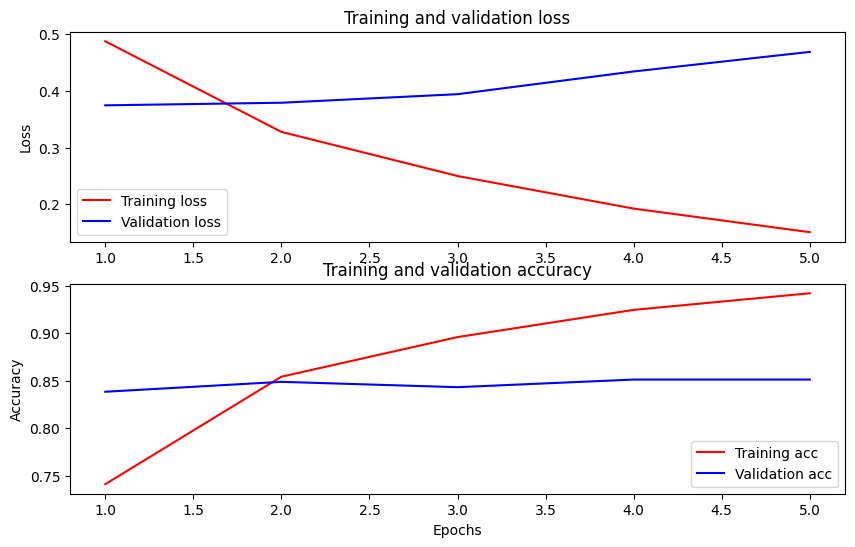

In [21]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Export for inference

Now you just save your fine-tuned model for later use.

In [22]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

Let's reload the model, so you can try it side by side with the model that is still in memory.

In [23]:
reloaded_model = tf.saved_model.load(saved_model_path)

Here you can test your model on any sentence you want, just add to the examples variable below.

In [24]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999256
input: The movie was great!           : score: 0.996352
input: The movie was meh.             : score: 0.941284
input: The movie was okish.           : score: 0.088899
input: The movie was terrible...      : score: 0.001742

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999256
input: The movie was great!           : score: 0.996352
input: The movie was meh.             : score: 0.941284
input: The movie was okish.           : score: 0.088899
input: The movie was terrible...      : score: 0.001742



If you want to use your model on [TF Serving](https://www.tensorflow.org/tfx/guide/serving), remember that it will call your SavedModel through one of its named signatures. In Python, you can test them as follows:

In [25]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.999256
input: The movie was great!           : score: 0.996352
input: The movie was meh.             : score: 0.941284
input: The movie was okish.           : score: 0.088899
input: The movie was terrible...      : score: 0.001742



## Next steps

As a next step, you can try [Solve GLUE tasks using BERT on a TPU tutorial](https://www.tensorflow.org/text/tutorials/bert_glue), which runs on a TPU and shows you how to work with multiple inputs.